# Análise de sequências de peptídeos para uso antiviral

In [1]:
# Instalação de bibliotecas necessárias

! pip3 install pandas
! pip3 install matplotlib
! pip3 install numpy
! pip3 install sklearn
! pip3 install torch
! pip3 install blosum

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no lon

In [2]:
# Importação de bibliotecas de uso geral

import pandas as pd
import sklearn
import statistics 
import matplotlib.pyplot as plt
from decimal import Decimal
import numpy as np

In [3]:
# Leitura do conjunto de dados

data = pd.read_csv('AVPdb.csv',sep=';')
display(data.head())

,Id,Sequence,Length,Virus,Abbreviation,Family,Nomenclature,Source,Uniprot,Cell_Line,Inhibition/IC50,Unit,Target,Assay,Accession,Title,Authors,Reference
0,AVP0001,PYVGSGLYRR,10,Avian myeloblastosis virus,AMV,Retroviridae,p2-p10,RSV gag polyprotein,P03354,-,50,μM,Release,Protease activity assay,1331099,Mechanism of inhibition of the retroviral prot...,"Cameron CE, Grinde B, Jentoft J, Leis J, Weber...",J Biol Chem. 1992
1,AVP0002,SMIENLEYM,9,Lymphocytic choriomeningitis virus,LCMV,Arenaviridae,-,Synthetic,NaN,MC57,50,μM,CTL lysis,In vitro cytotoxicity assay,1383569,Design of high-affinity major histocompatibili...,"Gairin JE, Oldstone MB.",J Virol. 1992
2,AVP0003,ECRSTSYAGAVVNDL,15,Herpes simplex virus 1,HSV 1,Herpesviridae,H2-(1-15),HSV ribonucleotide reductase subunit 2,P10224,BHK-21/C,42,μM,Replication,Ribonucleotide reductase assay,3040743,Structure-activity studies on synthetic peptid...,"Gaudreau P, Michaud J, Cohen EA, Langelier Y, ...",J Biol Chem. 1987
3,AVP0004,STSYAGAVVNDL,12,Herpes simplex virus 1,HSV 1,Herpesviridae,H2-(4-15),HSV ribonucleotide reductase subunit 2,P10224,BHK-21/C,29,μM,Replication,Ribonucleotide reductase assay,3040743,Structure-activity studies on synthetic peptid...,"Gaudreau P, Michaud J, Cohen EA, Langelier Y, ...",J Biol Chem. 1987
4,AVP0005,YAGAVVNDL,9,Herpes simplex virus 1,HSV 1,Herpesviridae,H2-(7-15),HSV ribonucleotide reductase subunit 2,P10224,BHK-21/C,60,μM,Replication,Ribonucleotide reductase assay,3040743,Structure-activity studies on synthetic peptid...,"Gaudreau P, Michaud J, Cohen EA, Langelier Y, ...",J Biol Chem. 1987


In [4]:
# Funções auxiliares para o processo

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve, roc_auc_score

# Validação cruzada em 10-folds que será utilizada em todo o trabalho
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def round_decimals(decimals):
    decimals_rounded = []
    for dec in decimals:
        decimals_rounded.append(Decimal(dec).quantize(Decimal('0.001')))
    return decimals_rounded

def plot_labeled_values(labels, values, xlabel, ylabel, title, rotate_x = False):
    rounded_values = round_decimals(values)
    plt.figure(figsize = (10, 5))
    plt.bar(labels, values)
    if(rotate_x):
        plt.xticks(rotation=30, ha='right')
    add_labels(labels, rounded_values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_roc_curve(fper, tper, color, label):  
    plt.plot(fper, tper, color=color, label=label)
    
def calc_plot_roc(clf, label, color, train_X, test_X, train_y, test_y):
    clf.fit(train_X, train_y)
    probs = clf.predict_proba(test_X)[:, 1]  
    fper, tper, thresholds = roc_curve(test_y, probs) 
    rocauc = roc_auc_score(test_y, probs)
    rocauc = Decimal(rocauc).quantize(Decimal('0.001'))
    plot_roc_curve(fper, tper, color, label + ': ' + str(rocauc))
    
def show_roc():
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taxa de falsos positivos')
    plt.ylabel('Taxa de positivos verdadeiros')
    plt.title('Curva ROC (Receiver Operating Characteristic)')
    plt.legend()
    plt.show()

def get_subsequences(input_sequence, size):
    sequence = input_sequence.replace(' ', '')
    subsequences = []
    if len(sequence) < size:
        seq = sequence
        while(len(seq) < size):
            seq = seq + '0'
        subsequences.append(seq)
        return subsequences
    n_subsequences = len(sequence) - size + 1
    for i in range(n_subsequences):
        subsequences.append(sequence[i:i+size])
    return subsequences

def extract_aminoacid_symbols(data):
    symbols = ['0']
    for index, x in data.iterrows():
        x_sequence = x['Sequence'].replace(' ', '')
        for x_symbol in x_sequence:
            present = False
            for symbol in symbols:
                if x_symbol == symbol:
                    present = True
                    break
            if not present:
                symbols.append(x_symbol)
    encoder = LabelEncoder()
    encoder.fit(symbols)
    return symbols, encoder

def build_basic_dataframe(data, size):
    subsequences = []
    virus_ids = []
    virus_abbreviations = []
    sars_cov = []
    hcv = []
    for index, x in data.iterrows():
        abbreviation = x['Abbreviation']
        x_subsequences = get_subsequences(x['Sequence'], size)
        for x_subsequence in x_subsequences:
            subsequences.append(x_subsequence)
            virus_abbreviations.append(abbreviation)
            hcv.append(1 if abbreviation == 'HCV' else 0)
            sars_cov.append(1 if abbreviation == 'SARS-CoV' else 0)
    encoder = LabelEncoder()
    encoder.fit(virus_abbreviations)
    virus_ids = encoder.transform(virus_abbreviations)
    return pd.DataFrame(list(zip(subsequences, virus_ids, hcv, sars_cov)), columns =['subsequence', 'virus_id', 'hcv', 'sars_cov']), encoder

def build_and_print_decision_tree(X, y, replaces):
    max_depth = 8
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    print('Decision Tree:', statistics.fmean(cross_val_score(clf, X, y, cv=k_fold, n_jobs=1)))
    clf.fit(X, y)
    tree_text = export_text(clf, feature_names=X.columns.tolist(), max_depth=max_depth)
    tree_text = tree_text.replace('class: 0', 'No SARS-CoV inhibition observed')
    tree_text = tree_text.replace('class: 1', 'Likely SARS-CoV inhibition observed')
    for r in replaces:
        tree_text = tree_text.replace(r[0], r[1])
    print(tree_text)

def benchmark_classifiers(X, y, plot_roc=True):
    nb_clf = GaussianNB()
    nb_accuracy = statistics.fmean(cross_val_score(nb_clf, X, y, cv=k_fold, n_jobs=1)) * 100
    knn_clf = KNeighborsClassifier()
    knn_accuracy = statistics.fmean(cross_val_score(knn_clf, X, y, cv=k_fold, n_jobs=1)) * 100
    svm_clf = SVC(random_state=0)
    svm_accuracy = statistics.fmean(cross_val_score(svm_clf, X, y, cv=k_fold, n_jobs=1)) * 100
    svm_clf = SVC(random_state=0, probability=True)
    rf_clf = RandomForestClassifier(random_state=0)
    rf_accuracy = statistics.fmean(cross_val_score(rf_clf, X, y, cv=k_fold, n_jobs=1)) * 100
    dt_clf = DecisionTreeClassifier(random_state=0)
    dt_accuracy = statistics.fmean(cross_val_score(dt_clf, X, y, cv=k_fold, n_jobs=1)) * 100
    labels = ['Naive Bayes', 'Decision Tree', 'SVM','K-Nearest Neighbors','Random Forest']
    accuracies = [nb_accuracy, dt_accuracy, svm_accuracy, knn_accuracy, rf_accuracy]
    plot_labeled_values(labels, accuracies, "Modelos", "Acurácia [%]", "Modelo x Acurácia obtida", rotate_x = True)
    if plot_roc:
        plt.figure(figsize = (10, 5))
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=0)
        calc_plot_roc(nb_clf, 'Naive Bayes', 'orange', train_X, test_X, train_y, test_y)
        calc_plot_roc(dt_clf, 'Decision Tree', 'blue', train_X, test_X, train_y, test_y)
        calc_plot_roc(svm_clf, 'SVM', 'green', train_X, test_X, train_y, test_y)
        calc_plot_roc(knn_clf, 'K-Nearest Neighbors', 'purple', train_X, test_X, train_y, test_y)
        calc_plot_roc(rf_clf, 'Random Forest', 'yellow', train_X, test_X, train_y, test_y)
        show_roc()

## Modelo de tradução posicional

Neste modelo cada posição de uma subsequência será modelada como uma feature e indicaremos qual aminoácido está presente em uma dada posição.

In [5]:
def build_encoder_translation_dataframe(data, size):
    df, virus_encoder = build_basic_dataframe(data, size)
    _, symbol_encoder = extract_aminoacid_symbols(data)
    translations = []
    for index, x in df.iterrows():
        subsequence = x['subsequence']
        subsequence_arr = []
        for s in subsequence:
           subsequence_arr.append(s) 
        encoded = symbol_encoder.transform(subsequence_arr)
        dictionary = {
            'virus_id': x['virus_id'],
            'sars_cov': x['sars_cov'],
            'hcv': x['hcv']
        }
        for i in range(size):
            dictionary['pos_'+str(i+1)] = encoded[i]
        translations.append(dictionary)
    return pd.DataFrame(translations), virus_encoder, symbol_encoder

In [6]:
df, virus_encoder, symbol_encoder = build_encoder_translation_dataframe(data, 8)
df.head()

,virus_id,sars_cov,hcv,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8
0,1,0,0,13,20,18,6,16,6,10,20
1,1,0,0,20,18,6,16,6,10,20,15
2,1,0,0,18,6,16,6,10,20,15,15
3,41,0,0,16,11,8,4,12,10,4,20
4,41,0,0,11,8,4,12,10,4,20,11


In [7]:
X = df.drop(columns=['virus_id', 'sars_cov', 'hcv'])

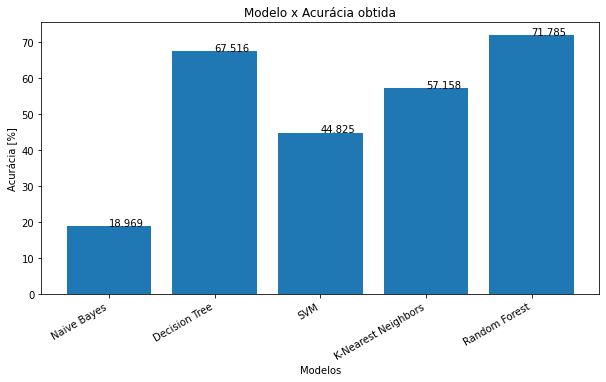

In [8]:
y = df['virus_id'].values.ravel()
benchmark_classifiers(X, y, plot_roc=False)

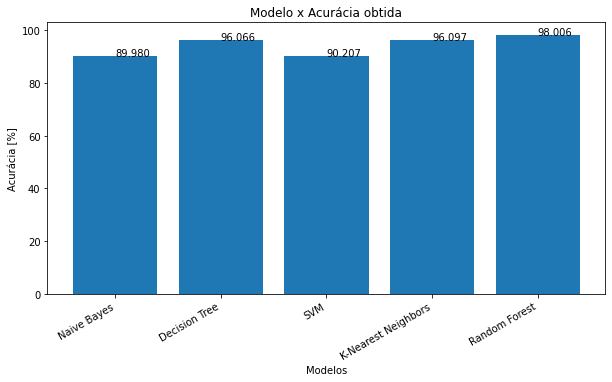

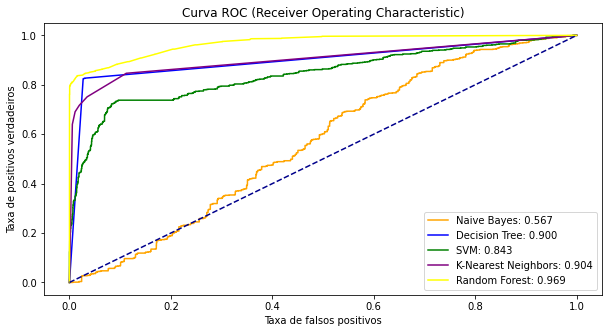

In [9]:
y = df['sars_cov'].values.ravel()
benchmark_classifiers(X, y)

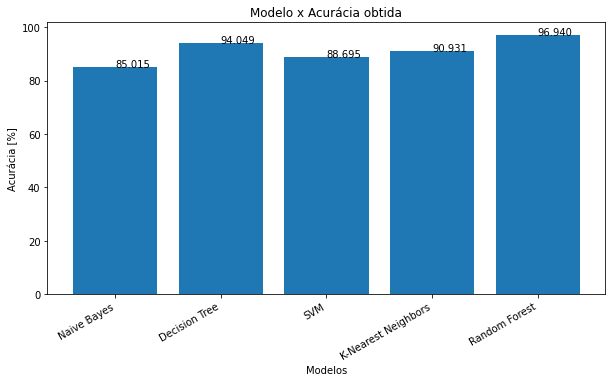

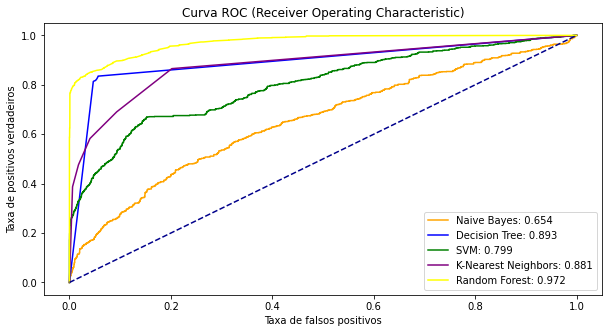

In [10]:
y = df['hcv'].values.ravel()
benchmark_classifiers(X, y)

## Modelo de posição dos aminoácidos

Neste modelo teremos `tamanho da subsequência` * `número de aminoácidos` features e cada uma delas indicará se um aminoácido está presente em uma dada posição, o modelo então será uma matriz bastante esparsa contendo apenas valores 0 ou 1.

In [11]:
def build_aminoacid_position_dataframe(data, size):
    df, virus_encoder = build_basic_dataframe(data, size)
    symbols, _ = extract_aminoacid_symbols(data)
    aminoacid_positions = []
    for index, x in df.iterrows():
        subsequence = x['subsequence']
        dictionary = {
            'virus_id': x['virus_id'],
            'sars_cov': x['sars_cov'],
            'hcv': x['hcv']
        }
        for i in range(len(subsequence)):
            if subsequence[i] != '0':
                dictionary[subsequence[i] + '_' + str(i+1)] = 1
            for s in symbols:
                if s != subsequence[i] and s != '0':
                    dictionary[s + '_' + str(i+1)] = 0
        aminoacid_positions.append(dictionary)
    return pd.DataFrame(aminoacid_positions), virus_encoder

In [12]:
df, virus_encoder = build_aminoacid_position_dataframe(data, 8)
df.head()

,virus_id,sars_cov,hcv,P_1,Y_1,V_1,G_1,S_1,L_1,R_1,...,N_8,C_8,T_8,A_8,D_8,K_8,F_8,Q_8,H_8,W_8
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,41,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X = df.drop(columns=['virus_id', 'sars_cov', 'hcv'])

In [ ]:
y = df['virus_id'].values.ravel()
benchmark_classifiers(X, y, plot_roc=False)

In [ ]:
y = df['sars_cov'].values.ravel()
benchmark_classifiers(X, y)

In [ ]:
y = df['hcv'].values.ravel()
benchmark_classifiers(X, y)

In [ ]:
y = df['sars_cov'].values.ravel()
replaces = []
replaces.append(['<= 0.50', '== False'])
replaces.append(['>  0.50', '== True'])
build_and_print_decision_tree(X, y, replaces)

## 2-Grams 

In [ ]:
def build_2_gram_subsequence_dataframe(data, size):
    df, virus_encoder = build_basic_dataframe(data, size)
    symbols, _ = extract_aminoacid_symbols(data)
    encoded_2_gram = []
    for index, x in df.iterrows():
        dictionary = {
            'virus_id': x['virus_id'],
            'sars_cov': x['sars_cov'],
            'hcv': x['hcv']
        }
        for s in symbols:
            if s != '0':
                dictionary[s] = 0
        for x_symbol in x['subsequence']:
            for s in symbols:
                if x_symbol == s and s != '0':
                    dictionary[s] = dictionary[s]+1
                    break
        encoded_2_gram.append(dictionary)
    return pd.DataFrame(encoded_2_gram), virus_encoder

In [ ]:
max_sequence_length = data['Sequence'].str.len().max()

### Subsequências de tamanho 8

In [ ]:
df, virus_encoder = build_2_gram_subsequence_dataframe(data, 8)
df.head()

In [ ]:
X = df.drop(columns=['virus_id', 'sars_cov', 'hcv'])

In [ ]:
y = df['virus_id'].values.ravel()
benchmark_classifiers(X, y, plot_roc=False)

In [ ]:
y = df['hcv'].values.ravel()
benchmark_classifiers(X, y)

In [ ]:
y = df['sars_cov'].values.ravel()
benchmark_classifiers(X, y)

### Sequências completas

In [ ]:
df, virus_encoder = build_2_gram_subsequence_dataframe(data, max_sequence_length)
df.head()

In [ ]:
X = df.drop(columns=['virus_id', 'sars_cov', 'hcv'])

In [ ]:
y = df['virus_id'].values.ravel()
benchmark_classifiers(X, y, plot_roc=False)

In [ ]:
y = df['hcv'].values.ravel()
benchmark_classifiers(X, y)

In [ ]:
y = df['sars_cov'].values.ravel()
benchmark_classifiers(X, y)

In [ ]:
build_and_print_decision_tree(X, y, [])

## BLOSUM50 orthonormal

In [ ]:
import blosum as bl
def build_blosum50_orthonormal_dataframe(data, size):
    blosum50 = dict(bl.BLOSUM(50))
    df, virus_encoder = build_basic_dataframe(data, size)
    symbols, _ = extract_aminoacid_symbols(data)
    aminoacid_positions = []
    for index, x in df.iterrows():
        subsequence = x['subsequence']
        dictionary = {
            'virus_id': x['virus_id'],
            'sars_cov': x['sars_cov'],
            'hcv': x['hcv']
        }
        for i in range(len(subsequence)):
            if subsequence[i] != '0':
                dictionary[subsequence[i] + '_' + str(i+1)] = blosum50[subsequence[i]+subsequence[i]]
            for s in symbols:
                if s != subsequence[i] and s != '0':
                    dictionary[s + '_' + str(i+1)] = 0
        aminoacid_positions.append(dictionary)
    return pd.DataFrame(aminoacid_positions), virus_encoder

In [ ]:
df, virus_encoder = build_blosum50_orthonormal_dataframe(data, 8)
df.head()

In [ ]:
X = df.drop(columns=['virus_id', 'sars_cov', 'hcv'])

In [ ]:
y = df['virus_id'].values.ravel()
benchmark_classifiers(X, y, plot_roc=False)

In [ ]:
y = df['hcv'].values.ravel()
benchmark_classifiers(X, y)

In [ ]:
y = df['sars_cov'].values.ravel()
benchmark_classifiers(X, y)